In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import numpy as np
import bayesfast as bf
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex=True) # comment this out if it does not work for you

bf.parallel.set_pool(4, 4)
mu_x = 0.6
sigma_x = 0.5
n_x = 4
x_fit = bf.utils.sobol.multivariate_normal(mu_x, sigma_x**2, n_x)
y_obs = 1.8
sigma_y = 0.25

class ToyDensity(bf.Density):
    def forward(self, x):
        cache_dict = {}
        y = self.module_hook('y(x)', cache_dict)(x)
        return -(y - y_obs)**2 / (2 * sigma_y**2), cache_dict

poly_0 = bf.PolyModel(bf.PolyConfig('<=quadratic', 1, 1), use_trust=True, center_max=False)
poly_1 = bf.PolyModel(bf.PolyConfig('<=quadratic', 1, 1), use_trust=False, center_max=False)
den_0 = ToyDensity({'y(x)': (lambda x: jnp.exp(x))}, {'y(x)': poly_0})
den_1 = ToyDensity({'y(x)': (lambda x: jnp.exp(x))}, {'y(x)': poly_1})

In [2]:
den_0.fit(den_0.cache(x_fit))
den_1.fit(den_1.cache(x_fit))
x_plot = np.linspace(-2, 1.5, 10000)[:, np.newaxis]
%time p_0_plot = np.exp(den_0.logp(x_plot))
%time q_0_plot = np.exp(den_0.logq(x_plot))
%time q_1_plot = np.exp(den_1.logq(x_plot))
%time p_0_fit = np.exp(den_0.logp(x_fit))

CPU times: user 3.79 s, sys: 702 ms, total: 4.5 s
Wall time: 4.5 s
CPU times: user 2.34 s, sys: 393 ms, total: 2.73 s
Wall time: 2.7 s
CPU times: user 2.19 s, sys: 444 ms, total: 2.63 s
Wall time: 2.57 s
CPU times: user 90.8 ms, sys: 92.6 ms, total: 183 ms
Wall time: 469 ms


In [3]:
%%time
with bf.parallel.get_pool() as pool:
    y_x_plot = np.exp(x_plot)
    y_0_plot = np.asarray(pool.map(poly_0, x_plot))
    y_1_plot = np.asarray(pool.map(poly_1, x_plot))
    y_x_fit = np.exp(x_fit)

CPU times: user 4.42 s, sys: 732 ms, total: 5.15 s
Wall time: 4.83 s


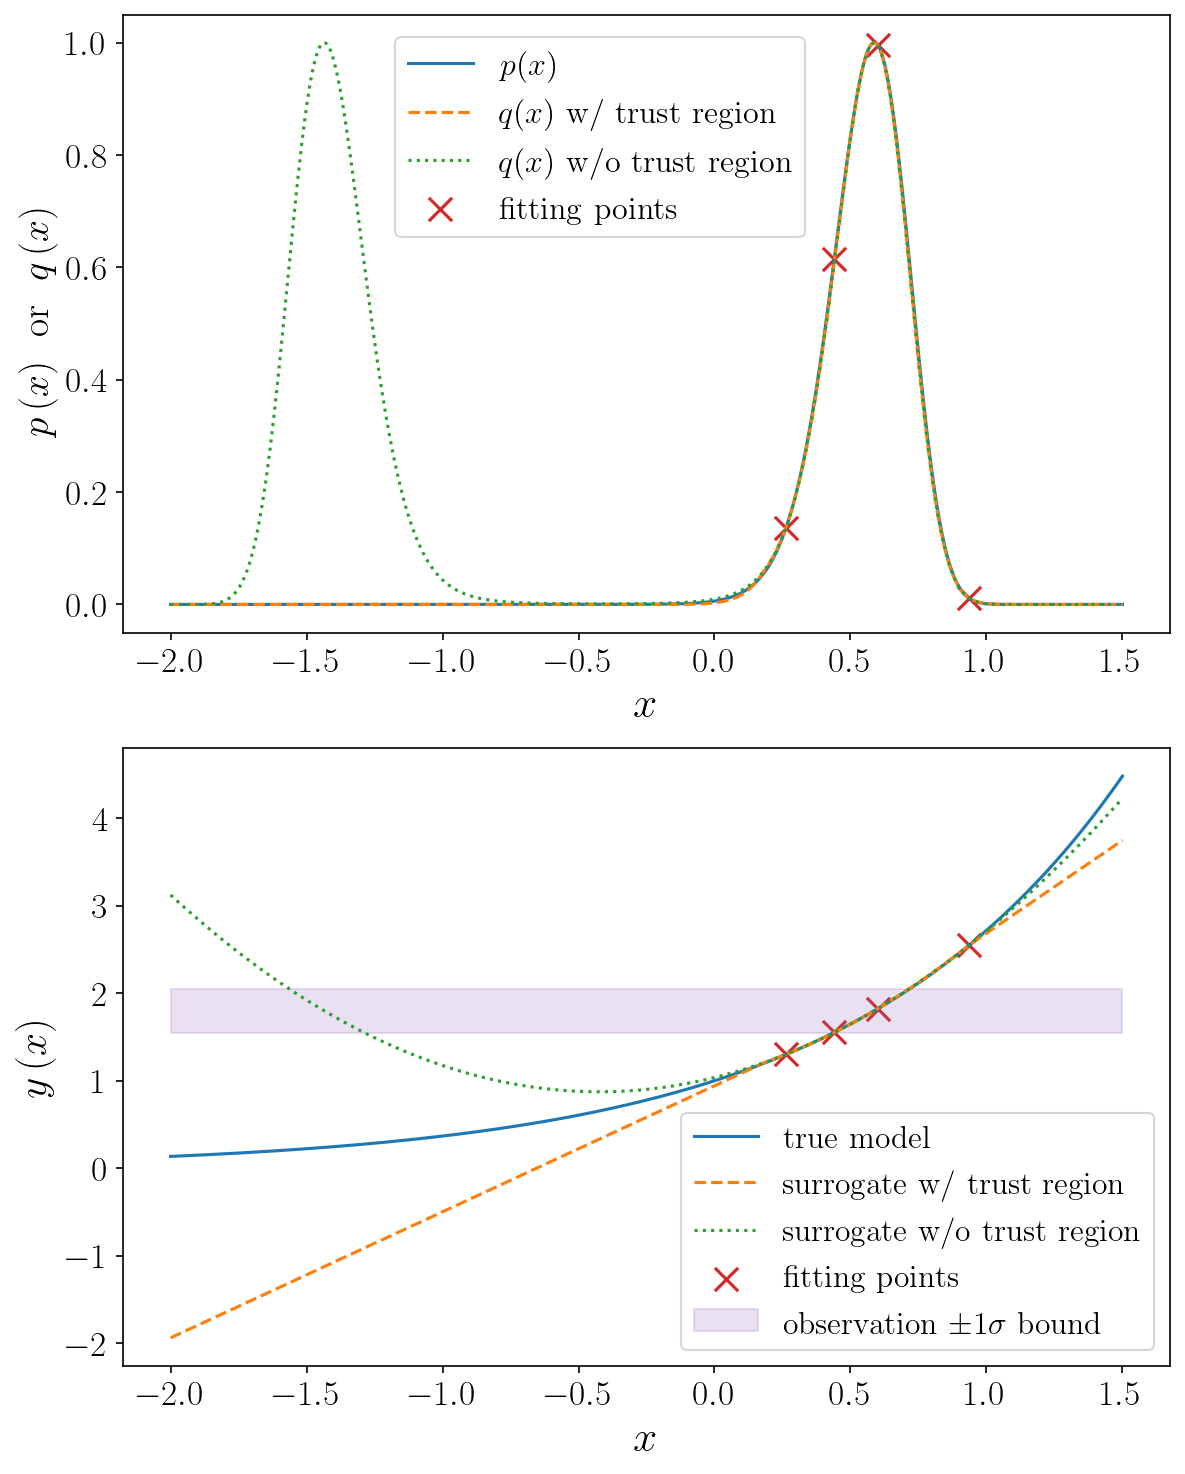

In [4]:
fig = plt.figure(figsize=(8, 10), dpi=150)
spec = fig.add_gridspec(nrows=2, ncols=1)

fig.add_subplot(spec[0, 0])
plt.plot(x_plot, p_0_plot, color='tab:blue', ls='solid', label=r'$p(x)$')
plt.plot(x_plot, q_0_plot, color='tab:orange', ls='dashed', label=r'$q(x)$ w/ trust region')
plt.plot(x_plot, q_1_plot, color='tab:green', ls='dotted', label=r'$q(x)$ w/o trust region')
plt.scatter(x_fit, p_0_fit, marker='x', s=125, color='tab:red', label=r'fitting points')
plt.legend(fontsize=15.5, loc=(0.26, 0.64))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('$x$', fontsize=21)
plt.ylabel('$p\,(x)\ \ $or$\ \ q\,(x)$', fontsize=19)

fig.add_subplot(spec[1, 0])
plt.plot(x_plot, y_x_plot, color='tab:blue', ls='solid', label=r'true model')
plt.plot(x_plot, y_0_plot, color='tab:orange', ls='dashed', label=r'surrogate w/ trust region')
plt.plot(x_plot, y_1_plot, color='tab:green', ls='dotted', label=r'surrogate w/o trust region')
plt.scatter(x_fit, y_x_fit, marker='x', s=125, color='tab:red', label=r'fitting points')
plt.fill_between([-2, 1.5], y_obs - sigma_y, y_obs + sigma_y, color='tab:purple', alpha=0.2, label=r'observation $\pm1\sigma$ bound')
plt.legend(fontsize=15.25, loc='lower right')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('$x$', fontsize=21)
plt.ylabel('$y\,(x)$', fontsize=20)

plt.tight_layout()
plt.show()